<h2><center>Stock Sentiment Analysis using News Data</center></h2>

In [1]:
from newsapi import NewsApiClient  # Used to fetch news articles using NewsAPI
import pandas as pd  # Used for data manipulation and analysis
import yfinance as yf  # Used to fetch stock price data from Yahoo Finance
import matplotlib.pyplot as plt  # Used for plotting graphs and visualizations
from transformers import pipeline  # Used to load sentiment analysis pipeline from Hugging Face
from matplotlib.dates import DateFormatter  # Used to format date labels on the x-axis of plots
from datetime import datetime, timedelta  # Used to handle date and time operations

In [2]:
from datetime import datetime, timedelta, UTC  # Import for date handling in UTC -> UTC stands for Coordinated Universal Time
from newsapi import NewsApiClient  # Import NewsAPI client to fetch news articles

# Set NewsAPI key and initialize client
NEWS_API_KEY = 'ce986691b8844929a21a020c68ecd9f7'  # NewsAPI key
newsapi = NewsApiClient(api_key=NEWS_API_KEY)  # Create NewsAPI client with the key

stock_code = 'AAPL'  # Stock ticker symbol for Apple Inc.
search_query = 'Apple'  # Keyword to search news articles about

# Define date range (past 30 days only, due to NewsAPI free plan)
end_date = datetime.now(UTC)  # Current date and time in UTC format
start_date = end_date - timedelta(days=30)  # 30 days ago from the end date

In [3]:
all_articles = newsapi.get_everything(q=search_query,                # Search articles containing the keyword
                                      from_param=start_date.date(),  # Start date for news (only date part)
                                      to=end_date.date(),            # End date for news (only date part)
                                      language='en',                 # Fetch only English articles
                                      sort_by='relevancy',           # Sort articles by relevance
                                      page_size=100)                 # Maximum 100 articles per request (free tier limit)

articles = all_articles['articles']                                # Extract list of articles from response
print(f"Fetched {len(articles)} articles")                         # Print number of articles fetched

Fetched 95 articles


In [4]:
# Load BERT sentiment model from Hugging Face hub for sentiment analysis
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

results = []  # List to store sentiment analysis results for each article

for article in articles:
    title = article['title']       # Get article title
    if not title:                  # Skip if title is None or empty
        continue
    result = classifier(title)[0]  # Run sentiment analysis on title, get first result
    label = result['label']        # Sentiment label (1 Star being a Negative and 5 Star being a Positive news)
    score = result['score']        # Confidence score of prediction
    results.append({
        'Datetime': article['publishedAt'],  # Article publish timestamp
        'title': title,                       # Store article title
        'label': label,                       # Store predicted sentiment label
        'score': score                        # Store sentiment score/confidence
    })

df = pd.DataFrame(results)                      # Convert list of dicts to DataFrame
df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)  # Convert to timezone-aware datetime
df.set_index('Datetime', inplace=True)          # Set datetime as DataFrame index
df.sort_index(inplace=True)                      # Sort DataFrame by datetime index ascending
print(df.head())                                 # Shows few results

Device set to use cpu


                                                                       title  \
Datetime                                                                       
2025-05-06 11:00:00+00:00  Trump’s Tariffs Are Threatening America’s Appl...   
2025-05-06 14:25:41+00:00  Apple Says These Five Games Are Coming to Appl...   
2025-05-06 18:28:05+00:00  Google teases Apple for stealing its design in...   
2025-05-06 20:46:38+00:00   Two Highly-Rated Apple TV+ Comedy Series Renewed   
2025-05-06 21:17:00+00:00       Here Are Apple's Full iOS 18.5 Release Notes   

                             label     score  
Datetime                                      
2025-05-06 11:00:00+00:00   1 star  0.464847  
2025-05-06 14:25:41+00:00  5 stars  0.562090  
2025-05-06 18:28:05+00:00   1 star  0.619872  
2025-05-06 20:46:38+00:00  5 stars  0.544292  
2025-05-06 21:17:00+00:00  5 stars  0.465099  


In [5]:
def convert_label(label):
    if '1' in label or '2' in label:   # If label has 1 or 2 stars, assign -1 (negative sentiment)
        return -1
    elif '3' in label:                 # If label is 3 stars, assign 0 (neutral sentiment)
        return 0
    else:                             # Otherwise (4 or 5 stars), assign 1 (positive sentiment)
        return 1

df['numeric_score'] = df['label'].apply(convert_label)  # Apply conversion to create numeric sentiment scores

In [6]:
df_daily = df.resample('D').mean(numeric_only=True)  # Resample data by day and calculate mean sentiment score for each day

df_daily['numeric_score'] = df_daily['numeric_score'].fillna(0) # Fill missing days (days without articles) with 0 sentiment (neutral)

In [7]:
# Download historical stock data for the given stock and date range
stock_data = yf.download(stock_code, start=start_date.date(), end=end_date.date()) 

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


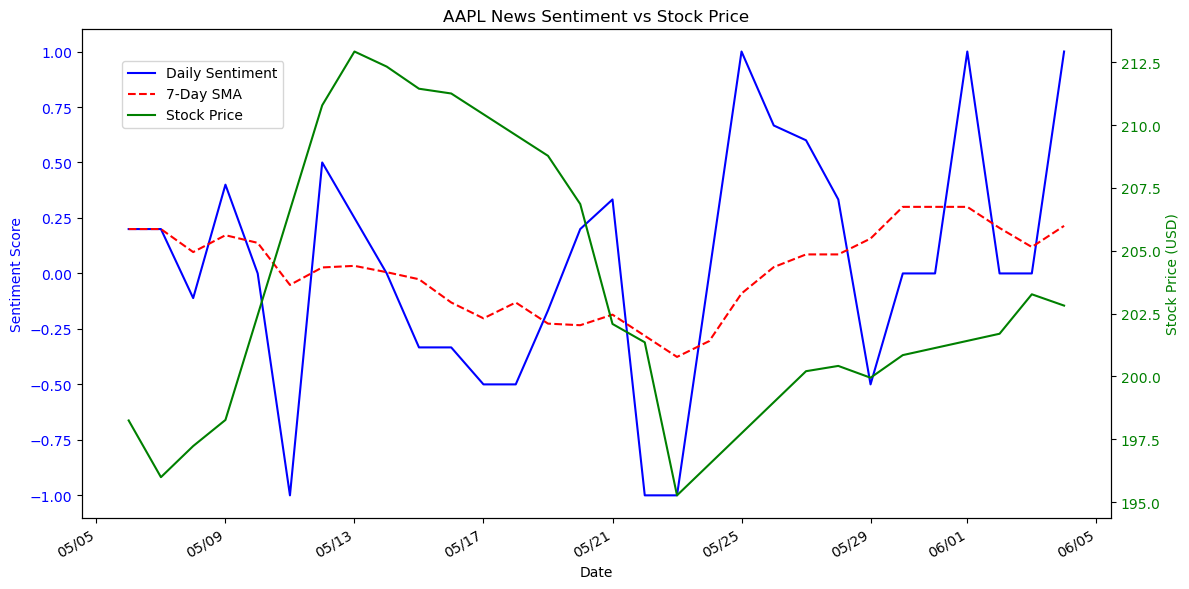

In [8]:
# Compute 7-day SMA -> Simple Moving Average
df_daily['sma_7d'] = df_daily['numeric_score'].rolling(window=7, min_periods=1).mean()

# Create plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot daily sentiment score
ax1.plot(df_daily.index, df_daily['numeric_score'], color='blue', label='Daily Sentiment')

# Plot 7-day SMA of sentiment
ax1.plot(df_daily.index, df_daily['sma_7d'], color='red', linestyle='--', label='7-Day SMA')

# Configure left axis for sentiment
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot stock closing price on secondary axis
ax2 = ax1.twinx()
ax2.plot(stock_data.index, stock_data['Close'], color='green', label='Stock Price')
ax2.set_ylabel('Stock Price (USD)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# X-axis formatting
ax1.set_xlabel('Date')
ax1.xaxis.set_major_formatter(DateFormatter('%m/%d'))
fig.autofmt_xdate()

# Title
plt.title(f'{stock_code.upper()} News Sentiment vs Stock Price')

# Correctly combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show plot
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
# Remove timezone info from the dates so both sentiment and stock data have matching date formats
df_daily.index = df_daily.index.tz_localize(None)  
stock_data.index = stock_data.index.tz_localize(None)  

# Create a new table with just the sentiment scores and stock closing prices, and remove any missing data
combined = pd.DataFrame({
    'sentiment': df_daily['numeric_score'].squeeze(),  # Sentiment score for each day
    'stock_price': stock_data['Close'].squeeze()       # Stock price at market close for each day
}).dropna()

# Calculate how different the sentiment scores are from the stock prices using common error measures
mae = mean_absolute_error(combined['stock_price'], combined['sentiment'])  # Average absolute difference
mse = mean_squared_error(combined['stock_price'], combined['sentiment'])   # Average squared difference
rmse = np.sqrt(mse)  # Square root of MSE to get error in original units

# Find how strongly the sentiment scores and stock prices move together (correlation)
corr, _ = pearsonr(combined['sentiment'], combined['stock_price'])

# Show the error values and correlation on screen
print(f" Mean Absolute Error (MAE): {mae:.4f}")
print(f" Mean Squared Error (MSE): {mse:.4f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f" Pearson Correlation: {corr:.4f}")

 Mean Absolute Error (MAE): 203.4053
 Mean Squared Error (MSE): 41404.5168
 Root Mean Squared Error (RMSE): 203.4810
 Pearson Correlation: 0.0842
